# - LAB3 : Custom_CNN model simple Implementation with MNIST, F-MNIST dataset (60 min)
#### LAB3 에서는 Pytorch의 모듈을 사용해여 CNN 모델을 간단히 구현해보고 MNIST와 F-MNIST 데이터셋에 대해 학습 및 Inference를 해볼 계획입니다.

## Example 1) Custom CNN 모델 구현 with MNIST dataset

![image.png](http://drive.google.com/uc?id=1H49c97VyvGZBWrpKuQ_hf5Nro7lpbsGJ)

In [1]:
# 패키지 import
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets, utils
from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# DEVICE 설정
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

# Parameter 설정
EPOCHS = 10
BATCH_SIZE = 64
LR = 0.01

# Transform 설정
transform_MNIST = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))# mean and std
])

### Q. 입력 데이터를 normalize 해야 하는 이유?
#### 1) 데이터가 가진 Feature의 스케일이 심하게 차이가 나는 경우 모델의 학습이 어려울 수 있음.
#### 2) 입력 값이 매우 높으면 메모리뿐만 아니라 많은 계산 시간이 걸리고, 모델이 느리게 수렴
![image.png](http://drive.google.com/uc?id=1zy7tVebn3LofaR-jCFL8cZfClre3Aa8g)

In [3]:
# Dataset 설정
train_dataset = datasets.MNIST(root = '../data',
                                         train = True,
                                         download = True,
                                         transform = transform_MNIST)

test_dataset = datasets.MNIST(root = '../data',
                                train = False,
                                download = True,
                                transform = transform_MNIST)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 85945866.39it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 86525495.59it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31257559.81it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15024076.32it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



![image.png](http://drive.google.com/uc?id=1oa6tP92fzCgz_ARwJPcOj1m92b8P7SHW)
![image.png](http://drive.google.com/uc?id=12reHf9xtapZrVBG4LlNbNGa37ZeFfUqk)
![image.png](http://drive.google.com/uc?id=17DgT11woHwXACEGOfvkVd8pYmxRI7vQl)

In [4]:
# Model 구현
class Custom_CNN(nn.Module):
    def __init__(self):
        super(Custom_CNN, self).__init__()
        '''
        super(Custom_CNN, self).__init__() 은 python 2.x 문법
        super().__init__() 은 python 3.x 문법
        --> 파이썬 3.x 에서는 2.x 버전의 문법도 함께 사용가능함.
        --> 범용성을 위해서는 파이썬 2.x 버전의 문법을 사용 추천
        '''
        ########################################## Complete This Code~!
        self.maxpool2d = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU(inplace=True)

        self.conv1 = nn.Conv2d(1,10,kernel_size=5)
        self.conv2 = nn.Conv2d(10,20,kernel_size=5)

        self.fc1 = nn.Linear(320,50)
        self.fc2 = nn.Linear(50,10)
        ########################################## Complete This Code~!

    def forward(self, x):
        ########################################## Complete This Code~!
        x = self.relu(self.conv1(x))
        x = self.maxpool2d(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool2d(x)
        x = x.view(-1,320)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        ########################################## Complete This Code~!
        return x

model = Custom_CNN().to(DEVICE)
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
              ReLU-2           [-1, 10, 24, 24]               0
         MaxPool2d-3           [-1, 10, 12, 12]               0
            Conv2d-4             [-1, 20, 8, 8]           5,020
              ReLU-5             [-1, 20, 8, 8]               0
         MaxPool2d-6             [-1, 20, 4, 4]               0
            Linear-7                   [-1, 50]          16,050
              ReLU-8                   [-1, 50]               0
            Linear-9                   [-1, 10]             510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 0.08
Estimated Total Size (MB): 0.21
---------------------------------------------

In [5]:
# Optimizer 설정
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.5)

In [6]:
# Train 구현
def train_one_epoch(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [7]:
# Evaluation 구현
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            # 배치 오차를 합산
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()

            # 가장 높은 값을 가진 인덱스가 바로 예측값
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

- Q. model.eval()을 사용하는 이유?

 : 모델링 시 training과 inference 시 다르게 동작하는 layer 들이 존재.
(예를 들어, Dropout, BatchNorm)

 - Dropout layer는 학습시에는 probability에 따라 일부 노드들만을 선택해 가중치곱을 하지만 inference시에는 모든 노드들의 가중치곱에다가 probability를 곱해주게 됨.

 - BatchNorm layer는 학습시에는 레이어의 인풋으로 들어온 Mini Batch의 Mean, Variance를 사용하여 정규화 하지만 Inference 시에는 Mean과 Variance를 알 수없음.
그렇기에 Training시 Mean, Varaince를 한번 사용하고 버리는 것이 아니고 Inference Mode에서의 사용을 위해 계속 지수이동평균으로 축적함. ( 지수이동평균식 = Momentum 계산식 : alpha는 Momentum이란 계수로 보통 0.9, 0.99, 0.999와 같이 1에 가까운 값을 사용 )

- Q. Evaluation 과정에서 loss.backward()를 사용하지 않아서 backpropagation을 안하면 되는데, 굳이 torch.no_grad()를 사용하는 이유?

 : torch.no_grad()를 with statement에 포함시키게 되면 Pytorch는 autograd engine을 꺼버림.
즉, gradient를 자동으로 트래킹하지 않게 된다.
Inference시에는 gradient를 사용할 필요가 없으므로 autograd를 끔으로써 메모리 사용량을 줄이고 연산 속도를 높인다.



In [8]:
# Train 및 Evaluate
for epoch in range(1, EPOCHS + 1):
    train_one_epoch(model, train_loader, optimizer, epoch)
    test_loss, test_accuracy = evaluate(model, test_loader)

    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.305610
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.912828
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.293499
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.341834
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.127679
[1] Test Loss: 0.1346, Accuracy: 95.88%
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.132841
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.053546
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.047897
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.204163
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.132870
[2] Test Loss: 0.0848, Accuracy: 97.55%
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.118962
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.110363
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.019157
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.031024
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.102517
[3] Test Loss: 0.0615, Accuracy: 98.12%
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.094558
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.071547
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.052229


In [9]:
# Datatset의 Class 프린트
CLASSES = dict()
for i in range(10) :
    CLASSES[i] = train_dataset.classes[i]
print(CLASSES)

{0: '0 - zero', 1: '1 - one', 2: '2 - two', 3: '3 - three', 4: '4 - four', 5: '5 - five', 6: '6 - six', 7: '7 - seven', 8: '8 - eight', 9: '9 - nine'}


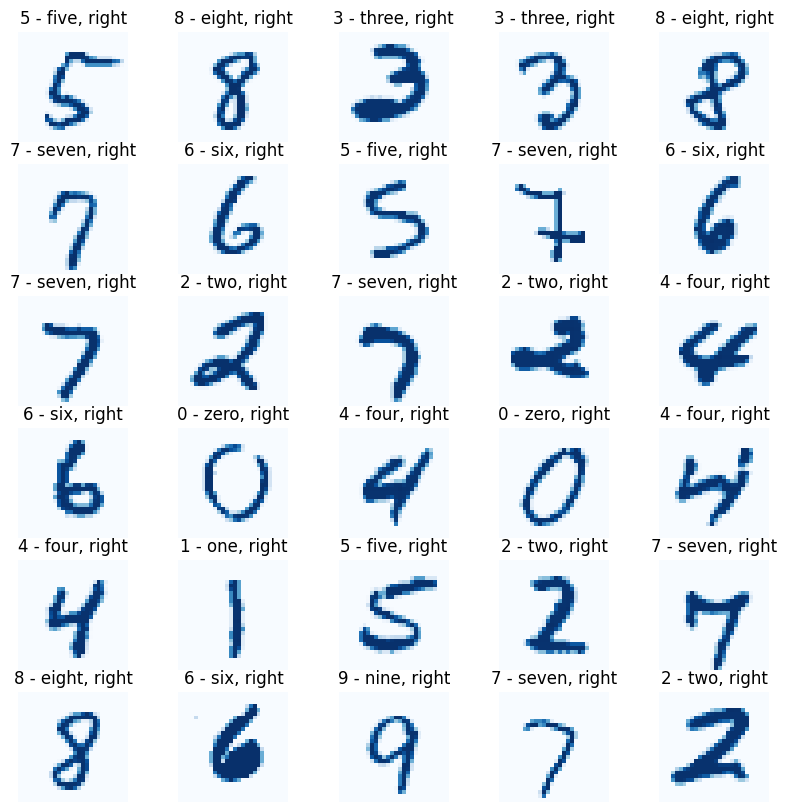

In [10]:
# Visualization
columns = 6
rows = 5
fig = plt.figure(figsize=(10,10)) # 가로 세로 10 인치 figure를 생성 (도화지 사이즈를 설정)
model.eval()
for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(test_dataset))
    input_img = test_dataset[data_idx][0].unsqueeze(dim=0).to(DEVICE) # model에 Input을 넣어줄 때는 4-Dim으로 넣어줘야함
    output = model(input_img)
    _, argmax = torch.max(output, dim=1)
    pred = CLASSES[argmax.item()]
    label = CLASSES[test_dataset[data_idx][1]]

    fig.add_subplot(columns, rows, i) # 세로를 columns 개수로 쪼개고, 가로를 rows 개수로 쪼갰을 때 i번째 칸을 설정 (도화지를 가로는 columns, 세로는 rows 개수로 잘라서 i번째 칸에 그림을 그리겠다고 설정)
    if pred == label:
        plt.title(pred + ', right')
        cmap = 'Blues'
    else:
        plt.title('N ' + pred + ' B ' +  label)
        cmap = 'Reds'
    plot_img = test_dataset[data_idx][0][0,:,:]
    plt.imshow(plot_img, cmap=cmap) # 그림을 그림 (cmap : 값을 표시하는 데 사용되는 컬러 맵)
    plt.axis('off') # 주변 네모 박스 등이 그려지면 그림이 별로 예쁘지 않게 보임
plt.show()

## Example 2) Custom CNN 모델 구현 with F-MNIST dataset

![image.png](http://drive.google.com/uc?id=1_A8JugM-133Rku7KJaK_CTS3zxkXbCPR)

In [11]:
# 패키지 import
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets, utils
from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np

# DEVICE 설정
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

# Parameter 설정
EPOCHS = 10
BATCH_SIZE = 64
LR = 0.01

# Transform 설정
transform_FashionMNIST = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))# mean and std
])

# Dataset 설정
train_dataset = datasets.FashionMNIST(root = '../data',
                                         train = True,
                                         download = True,
                                         transform = transform_FashionMNIST)

test_dataset = datasets.FashionMNIST(root = '../data',
                                train = False,
                                download = True,
                                transform = transform_FashionMNIST)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle=True)

100%|██████████| 26421880/26421880 [00:01<00:00, 16193506.75it/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 274508.63it/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5042326.98it/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 16961725.84it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



![image.png](http://drive.google.com/uc?id=1kXTkMcYDU1UCb2NFMZPTOYWmavJYAaqr)

![image.png](http://drive.google.com/uc?id=1m0RVhpddRxXmSfOKF9QqcN838-6_Fd2q)

![image.png](http://drive.google.com/uc?id=17DgT11woHwXACEGOfvkVd8pYmxRI7vQl)

In [13]:
# Model 구현
class Custom_CNN(nn.Module):
    def __init__(self):
        super(Custom_CNN, self).__init__()
        ########################################## Complete This Code~!
        self.maxpool2d = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU(inplace=True)

        self.conv1 = nn.Conv2d(1,10,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(10,20,kernel_size=3,padding=1)
        self.conv3 = nn.Conv2d(20,40,kernel_size=5,stride=1)
        self.conv4 = nn.Conv2d(40,60,kernel_size=5,stride=1)

        self.bn1 = nn.BatchNorm2d(10)
        self.bn2 = nn.BatchNorm2d(20)
        self.bn3 = nn.BatchNorm2d(40)
        self.bn4 = nn.BatchNorm2d(60)

        self.fc1 = nn.Linear(960,100)
        self.dropout = nn.Dropout2d(p=0.2)
        self.fc2 = nn.Linear(100,10)
        ########################################## Complete This Code~!

    def forward(self, x):
        ########################################## Complete This Code~!
        x = self.relu(self.bn1(self.conv1(x))) # (10, 28, 28)
        x = self.relu(self.bn2(self.conv2(x))) # (20, 28, 28)
        x = self.relu(self.bn3(self.conv3(x))) # (40, 24, 24)
        x = self.maxpool2d(x) # (40, 12, 12)
        x = self.relu(self.bn4(self.conv4(x))) # (60, 8, 8)
        x = self.maxpool2d(x) # (60, 4, 4)
        x = x.view(-1,960)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        ########################################## Complete This Code~!
        return x

model = Custom_CNN().to(DEVICE)
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]             100
       BatchNorm2d-2           [-1, 10, 28, 28]              20
              ReLU-3           [-1, 10, 28, 28]               0
            Conv2d-4           [-1, 20, 28, 28]           1,820
       BatchNorm2d-5           [-1, 20, 28, 28]              40
              ReLU-6           [-1, 20, 28, 28]               0
            Conv2d-7           [-1, 40, 24, 24]          20,040
       BatchNorm2d-8           [-1, 40, 24, 24]              80
              ReLU-9           [-1, 40, 24, 24]               0
        MaxPool2d-10           [-1, 40, 12, 12]               0
           Conv2d-11             [-1, 60, 8, 8]          60,060
      BatchNorm2d-12             [-1, 60, 8, 8]             120
             ReLU-13             [-1, 60, 8, 8]               0
        MaxPool2d-14             [-1, 6

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [14]:
# Optimizer 설정
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.5)

In [15]:
# Train 구현
def train_one_epoch(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

# Evaluation 구현
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            # 배치 오차를 합산
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()

            # 가장 높은 값을 가진 인덱스가 바로 예측값
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

# Train 및 Evaluate
for epoch in range(1, EPOCHS + 1):
    train_one_epoch(model, train_loader, optimizer, epoch)
    test_loss, test_accuracy = evaluate(model, test_loader)

    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.337614
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.590625
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.513059
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.369701
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.264151
[1] Test Loss: 0.3477, Accuracy: 87.50%
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.220594
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.221927
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.207879
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.132634
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.320975
[2] Test Loss: 0.2847, Accuracy: 89.72%
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.183774
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.117533
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.230775
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.388096
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.409117
[3] Test Loss: 0.2733, Accuracy: 89.80%
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.276572
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.245869
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.178810


In [16]:
# Datatset의 Class 프린트
CLASSES = dict()
for i in range(10) :
    CLASSES[i] = train_dataset.classes[i]
print(CLASSES)

{0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}


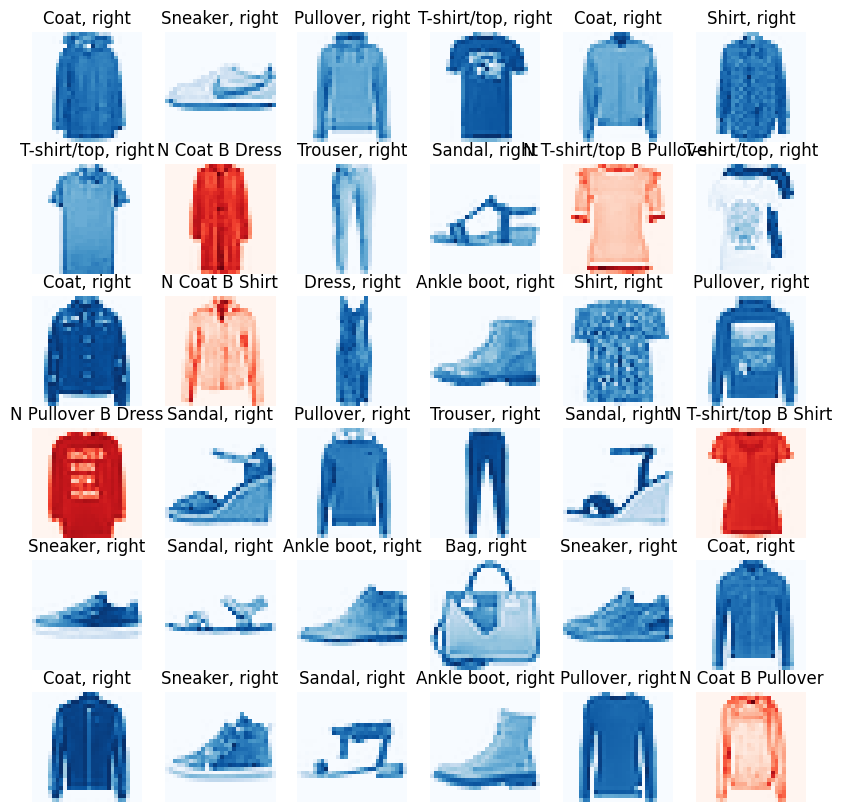

In [17]:
# Visualization
columns = 6
rows = 6
fig = plt.figure(figsize=(10,10))

model.eval()
for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(test_dataset))
    input_img = test_dataset[data_idx][0].unsqueeze(dim=0).to(DEVICE)

    output = model(input_img)
    _, argmax = torch.max(output, 1)
    pred = CLASSES[argmax.item()]
    label = CLASSES[test_dataset[data_idx][1]]

    fig.add_subplot(rows, columns, i)
    if pred == label:
        plt.title(pred + ', right')
        cmap = 'Blues'
    else:
        plt.title('N ' + pred + ' B ' +  label)
        cmap = 'Reds'
    plot_img = test_dataset[data_idx][0][0,:,:]
    plt.imshow(plot_img, cmap=cmap)
    plt.axis('off')

plt.show()

## Example 1) Custom CNN 모델 구현 with CIFAR-10 dataset

![image.png](http://drive.google.com/uc?id=1ygFHSGnUevJsDBXk8-_lPA-3LnuibtHY)

In [18]:
# 패키지 import
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets, utils
from torchsummary import summary
import matplotlib.pyplot as plt

# DEVICE 설정
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

# Parameter 설정
EPOCHS = 10
BATCH_SIZE = 64
LR = 0.01

# Transform 설정
transform_CIFAR10 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

# Dataset 설정
train_dataset = datasets.CIFAR10(root = '../data',
                                         train = True,
                                         download = True,
                                         transform = transform_CIFAR10)

test_dataset = datasets.CIFAR10(root = '../data',
                                train = False,
                                download = True,
                                transform = transform_CIFAR10)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle=True)

100%|██████████| 170498071/170498071 [00:01<00:00, 103573544.45it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


![image.png](http://drive.google.com/uc?id=118ueThyot5xi3XT8Eguni9q2HmXjejRB)

![image.png](http://drive.google.com/uc?id=17DgT11woHwXACEGOfvkVd8pYmxRI7vQl)

In [19]:
# Model 구현
class Custom_CNN(nn.Module):
    def __init__(self):
        super(Custom_CNN, self).__init__()
        ########################################## Complete This Code~!
        self.relu = nn.ReLU(inplace=True)
        self.maxpool2d_2 = nn.MaxPool2d(kernel_size=2)
        self.maxpool2d_4 = nn.MaxPool2d(kernel_size=4)
        self.dropout = nn.Dropout2d(p=0.5)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)
        ########################################## Complete This Code~!

    def forward(self, x): #(3,32,32)
        ########################################## Complete This Code~!
        x = self.maxpool2d_2(self.relu((self.conv1(x)))) #(64,16,16)
        x = self.maxpool2d_2(self.relu((self.conv2(x)))) #(32,8,8)
        x = self.maxpool2d_4(self.relu((self.conv3(x)))) #(16,2,2)
        x = x.view(-1,64)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        ########################################## Complete This Code~!
        return x

model = Custom_CNN().to(DEVICE)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]          18,464
              ReLU-5           [-1, 32, 16, 16]               0
         MaxPool2d-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 16, 8, 8]           4,624
              ReLU-8             [-1, 16, 8, 8]               0
         MaxPool2d-9             [-1, 16, 2, 2]               0
           Linear-10                   [-1, 64]           4,160
             ReLU-11                   [-1, 64]               0
           Linear-12                   [-1, 64]           4,160
             ReLU-13                   [-1, 64]               0
           Linear-14                   

In [20]:
# Optimizer 설정
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.5)

In [21]:
# Train 구현
def train_one_epoch(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

# Evaluation 구현
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            # 배치 오차를 합산
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()

            # 가장 높은 값을 가진 인덱스가 바로 예측값
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

# Train 및 Evaluate
for epoch in range(1, EPOCHS + 1):
    train_one_epoch(model, train_loader, optimizer, epoch)
    test_loss, test_accuracy = evaluate(model, test_loader)

    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.287494
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.296834
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.289052
Train Epoch: 1 [38400/50000 (77%)]	Loss: 2.207172
[1] Test Loss: 2.0407, Accuracy: 25.51%
Train Epoch: 2 [0/50000 (0%)]	Loss: 2.071552
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.838234
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.819950
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.583566
[2] Test Loss: 1.6945, Accuracy: 36.96%
Train Epoch: 3 [0/50000 (0%)]	Loss: 1.910089
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.718982
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.680908
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.766136
[3] Test Loss: 1.5217, Accuracy: 44.66%
Train Epoch: 4 [0/50000 (0%)]	Loss: 1.499324
Train Epoch: 4 [12800/50000 (26%)]	Loss: 1.472569
Train Epoch: 4 [25600/50000 (51%)]	Loss: 1.395389
Train Epoch: 4 [38400/50000 (77%)]	Loss: 1.136544
[4] Test Loss: 1.3980, Accuracy: 48.95%
Train Epoch: 5 [0/50000 (0%)]	Loss: 1.279997
Train Epoch: 5 

In [22]:
# Datatset의 Class 프린트
CLASSES = dict()
for i in range(10) :
    CLASSES[i] = train_dataset.classes[i]
print(CLASSES)

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


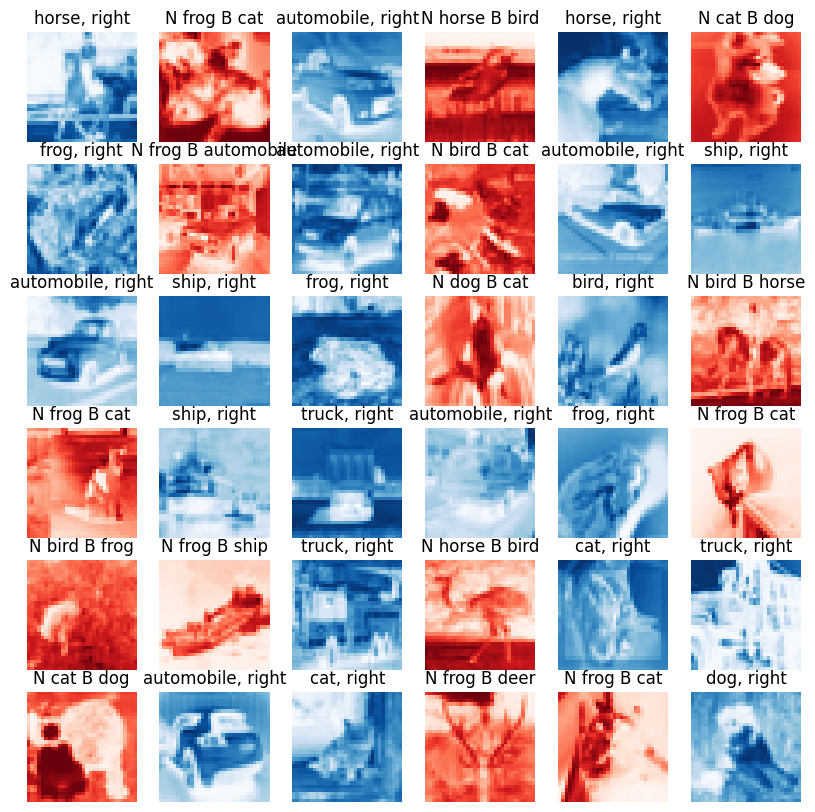

In [23]:
# Visualization
columns = 6
rows = 6
fig = plt.figure(figsize=(10,10))

model.eval()
for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(test_dataset))
    input_img = test_dataset[data_idx][0].unsqueeze(dim=0).to(DEVICE)

    output = model(input_img)
    _, argmax = torch.max(output, 1)
    pred = CLASSES[argmax.item()]
    label = CLASSES[test_dataset[data_idx][1]]

    fig.add_subplot(rows, columns, i)
    if pred == label:
        plt.title(pred + ', right')
        cmap = 'Blues'
    else:
        plt.title('N ' + pred + ' B ' +  label)
        cmap = 'Reds'
    plot_img = test_dataset[data_idx][0][0,:,:]
    plt.imshow(plot_img, cmap=cmap)
    plt.axis('off')

plt.show()